<a href="https://colab.research.google.com/github/srv-sh/image-captioning/blob/main/image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q kaggle


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"souravsaha058","key":"6f58508da21d5285bba6faa1e69375d3"}'}

In [4]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/





In [5]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [6]:
 ! kaggle datasets list

ref                                                           title                                              size  lastUpdated          downloadCount  
------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                   Reddit Vaccine Myths                              232KB  2021-06-29 20:28:10           8557  
crowww/a-large-scale-fish-dataset                             A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           5219  
imsparsh/musicnet-dataset                                     MusicNet Dataset                                   22GB  2021-02-18 14:12:19           1829  
promptcloud/careerbuilder-job-listing-2020                    Careerbuilder Job Listing 2020                     42MB  2021-03-05 06:59:52           1203  
coloradokb/dandelionimages                                    Da

In [7]:
!kaggle datasets download -d hsankesara/flickr-image-dataset

100% 8.16G/8.16G [03:08<00:00, 32.3MB/s]
100% 8.16G/8.16G [03:08<00:00, 46.6MB/s]


In [8]:
!unzip flickr-image-dataset.zip && rm flickr-image-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5354911151.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535529555.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356236664.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356318668.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535830521.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5359437945.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361355399.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/53614287.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536147209.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361551308.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536156200.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/

In [9]:
import tensorflow
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import random
import pandas as pd
from tensorflow.keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences

In [10]:
# import libs
import torch
import os # when loading file path
import pandas as pd
import spacy #for tokenizer
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader , Dataset
from PIL import Image # load img
import torchvision.transforms as transforms
spacy_eng = spacy.load("en")

In [11]:
# We want to convert text => numerical values
#1.we need a Vocabulary mapping each word to a index
#2. We need to setup a pytorch dataset to load the data
#3. Setup padding of every batch (all example should be of same seq_len and setup dataloader)
#

In [12]:
import matplotlib.pyplot as plt
def show_image(img, title = None):
  #Imshow for Tensor

  #unnormalize
  img[0] = img[0] * 0.229
  img[1] = img[1] * 0.224
  img[2] = img[2] * .225
  img[0] += 0.485
  img[1] += 0.456
  img[2] += 0.406

  img = img.numpy().transpose((1,2,0))

  plt.imshow(img)

  if title is not None:
    plt.title(title)
  plt.pause(0.001) #pause a bit so that plots are updated

In [13]:
# Vocabulary class
class Vocabulary:
  def __init__(self, freq_threshold):
    self.itos = {0:"<PAD>", 1:"<SOS>", 2:"EOS", 3:"<UNK>"}
    self.stoi = {"<PAD>" : 0 , "<SOS>" : 1 , "<EOS>" : 2 , "<UNK>" :3}
    self.freq_threshold = freq_threshold
  def __len__(self):
    return len(self.itos)
  
  @staticmethod
  def tokenizer_eng(text):
    return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

  def build_vocabulary(self, sentence_list):
    frequencies = {}
    idx = 4

    for sentence in sentence_list:
      for word in self.tokenizer_eng(str(sentence)):
        if word not in frequencies:
          frequencies[word] = 1
        else:
          frequencies[word] += 1
        if frequencies[word] == self.freq_threshold:
          self.stoi[word] = idx
          self.itos[idx] = word
          idx += 1
  
  def numericalize(self, text):
    tokenized_text = self.tokenizer_eng(text)

    return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
    ]


    

  
  
  

In [14]:

class FlickrDataset(Dataset):
  def __init__(self,root_dir, caption_file , transform = None, freq_threshold =5):
    self.root_dir = root_dir
    self.df = pd.read_csv(caption_file, delimiter= '|')
    self.transform = transform
    # get img , caption columns

    self.imgs = self.df['image_name']
    self.captions = self.df[ ' comment']
    #initialize vocabulary and build vocab
    self.vocab = Vocabulary(freq_threshold)
    self.vocab.build_vocabulary(self.captions.tolist())

  def __len__(self):
    return len(self.df)

  def __getitem__(self,index):
    caption = self.captions[index]
    img_id = self.imgs[index]
    img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")
      
    if self.transform is not None:
      img = self.transform(img)
      
    numericalized_caption  = [self.vocab.stoi["<SOS>"]]
    numericalized_caption += self.vocab.numericalize(caption)
    numericalized_caption.append(self.vocab.stoi["<EOS>"])
      
    return img , torch.tensor(numericalized_caption)



In [15]:
class MyCollate:
  def __init__(self, pad_idx):
    self.pad_idx = pad_idx
  def __call__(self, batch):
    imgs = [item[0].unsqueeze(0) for item in batch]
    imgs = torch.cat(imgs , dim=0)
    targets = [item[1] for item in batch]
    targets = pad_sequence(targets , batch_first = False , padding_value = self.pad_idx)

    return imgs , targets


In [28]:
def get_loader(
    root_folder,
    annotation_file,
    transform, 
    batch_size = 32,
    num_workers = 8,
    shuffle = True,
    pin_memory = True,
):
  dataset = FlickrDataset(root_folder , annotation_file , transform = transform)
  pad_idx = dataset.vocab.stoi["<PAD>"]

  loader = DataLoader(
      dataset = dataset,
      batch_size = batch_size,
      num_workers = num_workers,
      shuffle = shuffle,
      pin_memory = pin_memory,
      collate_fn = MyCollate(pad_idx = pad_idx)
  )
  return loader



In [17]:
#defining the transform to be applied
transform = transforms.Compose(
    [
     transforms.Resize(256),
     transforms.RandomCrop(224),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ]
)

In [18]:
BATCH_SIZE = 32
NUM_WORKER = 8



In [19]:
#test the dataset class
dataset = FlickrDataset(root_dir="/content/flickr30k_images/flickr30k_images/",
                          caption_file = "/content/flickr30k_images/results.csv",
                          transform = transform)
#writing the dataloader
data_loader = get_loader("/content/flickr30k_images/flickr30k_images/",
                          annotation_file = "/content/flickr30k_images/results.csv",
                          batch_size = BATCH_SIZE,
                          transform= transform )




# Building model 

In [20]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

## CNN Encoder 

In [21]:


class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        #print(features.shape)
        return features

# RNN Decoder

In [29]:
class DecoderRNN(nn.Module):
    def __init__(self,embed_size, hidden_size, vocab_size, num_layers=1,drop_prob=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.lstm = nn.LSTM(embed_size,hidden_size,num_layers=num_layers,batch_first=True)
        self.fcn = nn.Linear(hidden_size,vocab_size)
        self.drop = nn.Dropout(drop_prob)
    
    def forward(self, features, captions):
        
        #vectorize the caption
        embeds = self.embedding(captions)
        #print(embeds.shape)
        #concat the features and captions
        x = torch.cat((features.unsqueeze(0),embeds),dim=0) 
        x,_ = self.lstm(x)
        x = self.fcn(x)
        #print(x.shape)
        return x
    
    def generate_caption(self,inputs,hidden=None,max_len=20,vocab=None):
        # Inference part
        # Given the image features generate the captions
        
        batch_size = inputs.size(0)
        #batch_size = 32
        
        captions = []
        
        for i in range(max_len):
            output,hidden = self.lstm(inputs,hidden)
            output = self.fcn(output)
            output = output.view(batch_size,-1)
        
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            
            #send generated word as the next caption
            inputs = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions]

# CNN To RNN

In [30]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, hidden_size, vocab_size, num_layers=1,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN(embed_size)
        self.decoder = DecoderRNN(embed_size,hidden_size,vocab_size,num_layers,drop_prob)
    
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Train the model

In [32]:
!pip install utils

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
#from utils import lead_checkpoint , print_examples
import utils
#from utils import lead_checkpoint , print_examples

Epoch: 1 loss: 4.67513
<SOS> <SOS> <SOS>     a a a a a a a a a a a a a a a


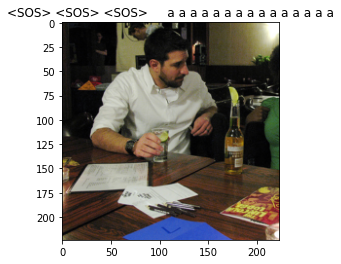

In [ ]:

# Hyperparameters
embed_size = 400
hidden_size = 512
vocab_size = len(dataset.vocab)
num_layers = 2
learning_rate = 0.0001
num_epochs = 0




# initialize model, loss etc
model = EncoderDecoder(embed_size, hidden_size, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 20
print_every = 100

for epoch in range(1,num_epochs+1):   
    for idx, (image, captions) in enumerate(iter(data_loader)):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        
        outputs = model(image, captions[:-1])
        
        # Calculate the batch loss.
        #loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
        loss = criterion(outputs.reshape(-1,outputs.shape[2]),captions.reshape(-1))
        
        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()
        
        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
            
            
            #generate the caption
            model.eval()
            with torch.no_grad():
                dataiter = iter(data_loader)
                img,_ = next(dataiter)
                features = model.encoder(img[0:1].to(device))
                caps = model.decoder.generate_caption(features.unsqueeze(0),vocab=dataset.vocab)
                caption = ' '.join(caps)
                print(caption)
                show_image(img[0],title= caption)
                
            model.train()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


ValueError: ignored

In [ ]:
train_image_list = os.listdir('/content/flickr30k_images/flickr30k_images')
train_image_list

['7199344342.jpg',
 '2107837987.jpg',
 '414574330.jpg',
 '3721082512.jpg',
 '97131520.jpg',
 '530170010.jpg',
 '1506789462.jpg',
 '2644430445.jpg',
 '3098463915.jpg',
 '4783176272.jpg',
 '2148916767.jpg',
 '2957682838.jpg',
 '2373370266.jpg',
 '2307886611.jpg',
 '4944826636.jpg',
 '6303619277.jpg',
 '5738179350.jpg',
 '4798971292.jpg',
 '3304511635.jpg',
 '3474999131.jpg',
 '584726817.jpg',
 '257699783.jpg',
 '101669240.jpg',
 '1019077836.jpg',
 '2057420842.jpg',
 '2599100984.jpg',
 '4868221344.jpg',
 '6989577015.jpg',
 '4681944456.jpg',
 '3003011417.jpg',
 '2900680078.jpg',
 '3587666993.jpg',
 '2772793352.jpg',
 '7630279850.jpg',
 '862177617.jpg',
 '2221818690.jpg',
 '4738365740.jpg',
 '5523586446.jpg',
 '3336374196.jpg',
 '2469638631.jpg',
 '7808530252.jpg',
 '3505587834.jpg',
 '3565917449.jpg',
 '6886050898.jpg',
 '3696190497.jpg',
 '5419038647.jpg',
 '6400126225.jpg',
 '4855663504.jpg',
 '4756096577.jpg',
 '136552115.jpg',
 '356929855.jpg',
 '2378127945.jpg',
 '2519812011.jpg',
 '2

In [ ]:
metadata = pd.read_csv('/content/flickr30k_images/results.csv', delimiter = '|' , engine='python')
metadata = metadata.dropna()
is_NaN = metadata.isnull()
row_has_NaN = is_NaN.any(axis = 1)
row_with_NaN = metadata[row_has_NaN]
print(row_with_NaN)
metadata.head()

Empty DataFrame
Columns: [image_name,  comment_number,  comment]
Index: []


,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


# Number of samples

In [ ]:
len(metadata['image_name'].unique())

31783

# Read the Data

In [ ]:
def load_image(name):
    img = image.load_img(name,target_size=(32,32,3))
    img = image.img_to_array(img)
    #img = img/255
    #plt.imshow(img)
    img = np.reshape(img,(32*32*3))
    return img

In [ ]:
sample_size = len(metadata['image_name'].unique())
train_image_list = train_image_list[:sample_size]

In [ ]:
size = (32,32)
num_channels = 3


In [ ]:
train = np.array([None]* sample_size)
real_images = np.array([None] * sample_size)

In [ ]:
image_arr = []
sentence_arr = []
for ind in range(5000):
  if ind % 5 != 0:
    continue
  image_location =(metadata.iloc[ind,:]['image_name'])
  sentence = (metadata.iloc[ind,:][' comment'])
  image_arr.append(load_image('/content/flickr30k_images/flickr30k_images/'+ str(image_location)))
  sentence_arr.append('<SOS>' + sentence + '<EOS>') 
image = np.array(image_arr) 


In [ ]:
image

array([[  7.,  12.,   8., ..., 117., 167.,  94.],
       [134., 134., 134., ..., 214., 216., 213.],
       [ 96., 115.,  83., ..., 173., 199., 174.],
       ...,
       [ 85., 161., 239., ..., 234., 234., 232.],
       [ 69.,  65.,  36., ...,  96., 104., 107.],
       [ 90.,  81.,  84., ...,  12.,   7.,   4.]], dtype=float32)

In [ ]:
j = 0 
for i in train_image_list:
  real_images[j] = np.array(plt.imread('/content/flickr30k_images/flickr30k_images/'+ i))
  train[j] = real_images[j]
  j += 1

UnidentifiedImageError: ignored

In [ ]:
j =0 
for i in train:
  train[j] = cv2.resize(i, size)
  train[j] = train[j].reshape(1 , size[0] , size[1] , num_channels)
  j +=1

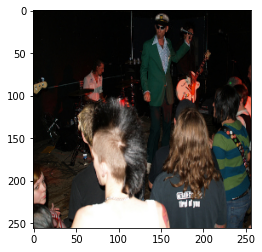

In [ ]:
plt.imshow(np.squeeze(train[29]))
plt.show()

In [ ]:
import pandas as pd


In [ ]:
train_captions = pd.read_csv('/content/flickr30k_images/results.csv', delimiter= '|')

In [ ]:
train_captions.columns = ['image_name', 'comment_number', 'comment']

In [ ]:
def images_map_caption(train_images_list , train_captions):
  caption = []
  for i in train_images_list:
    caption.append(train_captions[train_captions['image_name']== i]['comment'].iat[0])
  return caption

In [ ]:
captions = np.array(images_map_caption(train_images_list , train_captions))

In [ ]:
print(captions.shape)

(30,)


In [ ]:
captions[29]

" A man in a green jacket and captain 's hat is on stage performing in front of an audience ."

In [ ]:


import re

start_tag = '<SOS>'
end_tag = '<EOS>'

In [ ]:
def get_vocab(captions):
  arr = []
  m = captions.shape[0]
  sentence = [None] * m
  j = 0
  for i in captions:
    i = re.sub(' +',' ',i)
    i = start_tag+ ' ' + i + ' '+end_tag
    sentence[j] = i.split()
    j += 1
    arr = arr  + i.split()
  arr = list(set(arr))
  vocab_size = len(arr)
  j =0 
  fwd_dict = {}
  rev_dict = {}
  j = 0
  for i in arr:
    fwd_dict[i] = j
    rev_dict[j] = i
    j+= 1
  return vocab_size , sentence , fwd_dict , rev_dict




In [ ]:
vocab_size , sentences , fwd_dict , rev_dict = get_vocab(captions)

In [ ]:
!cp ../input/data-loader/data_loader.py .

cp: cannot stat '../input/data-loader/data_loader.py': No such file or directory


# Image Captioning With Attention

In [ ]:
#location if the training data
data_location = "/content/flickr30k_images"
#
from data_loader import FlickrDataset,get_data_loader

ModuleNotFoundError: ignored